In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

import utils
from monster import Kraken

/Users/andrea/anaconda/envs/mlenv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('data/train_predictedAge.csv')

X = train.drop(['CUST_COD', 'DEFAULT PAYMENT JAN'], axis = 1)
y = train['DEFAULT PAYMENT JAN']

# Perform feature selection

In [3]:
%%time

rfecv = RFECV(estimator=XGBClassifier(base_score=0.2, max_depth=3, n_estimators=80), step=2, cv=StratifiedKFold(5).split(X, y), n_jobs=-1, verbose=2)
rfecv.fit(X, y)

Fitting estimator with 81 features.
Fitting estimator with 81 features.
Fitting estimator with 81 features.
Fitting estimator with 81 features.
Fitting estimator with 81 features.
Fitting estimator with 79 features.
Fitting estimator with 79 features.
Fitting estimator with 79 features.
Fitting estimator with 79 features.
Fitting estimator with 79 features.
Fitting estimator with 77 features.
Fitting estimator with 77 features.
Fitting estimator with 77 features.
Fitting estimator with 77 features.
Fitting estimator with 77 features.
Fitting estimator with 75 features.
Fitting estimator with 75 features.
Fitting estimator with 75 features.
Fitting estimator with 75 features.
Fitting estimator with 75 features.
Fitting estimator with 73 features.
Fitting estimator with 73 features.
Fitting estimator with 73 features.
Fitting estimator with 73 features.
Fitting estimator with 73 features.
Fitting estimator with 71 features.
Fitting estimator with 71 features.
Fitting estimator with 71 fe

Optimal number of features : 51


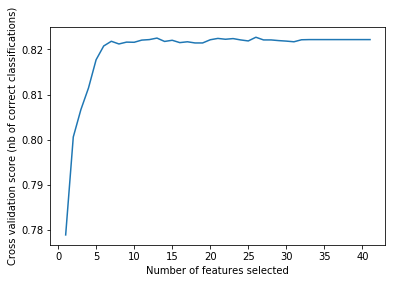

In [4]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [5]:
features = rfecv.get_support()
X.columns[features]

Index(['LIMIT_BAL', 'SEX', 'PAY_DEC', 'PAY_AUG', 'PAY_JUL', 'BILL_AMT_DEC',
       'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
       'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP',
       'PAY_AMT_AUG', 'PAY_AMT_JUL', 'EDUCATION_other', 'MARRIAGE_married',
       'AGE', 'LIMIT-MEAN_BILL', 'AVG_PAY_LAST_2', 'AVG_PAY_LAST_3',
       'AVG_PAY_LAST_4', 'AVG_PAY_LAST_5', 'AVG_PAY_LAST_6', 'PAY_TREND',
       'PAY_SKEW', 'AVG_BILL_AMT_LAST_2', 'AVG_BILL_AMT_LAST_3',
       'AVG_BILL_AMT_LAST_5', 'AVG_BILL_AMT_LAST_6', 'BILL_AMT_TREND',
       'BILL_AMT_SKEW', 'BILL_AMT_KURT', 'AVG_PAY_AMT_LAST_2',
       'AVG_PAY_AMT_LAST_4', 'AVG_PAY_AMT_LAST_6', 'PAY_AMT_TREND',
       'PAY_AMT_SKEW', 'PAY_AMT_KURT', 'DELTA_1', 'DELTA_3', 'DELTA_4',
       'DELTA_5', 'FRAC_PAY_2', 'FRAC_PAY_3', 'FRAC_PAY_4', 'FRAC_PAY_5',
       'BILL_AMT_SIGMA', 'PAY_AMT_SIGMA', 'PAY_SIGMA'],
      dtype='object')

In [6]:
X_train = X.loc[:, features]

# Unleash the Kraken!!

In [7]:
# We also tried other models (Logistic regression, MLPClassifier, AdaBoost, ...), 
# but we have reported only the best performing ones.
# Note that also the choice of the parameters is not random, but we tried to reduce the computations in this notebook

xgb_params = {
    'base_score' : [0.2],
    'max_depth' : [2],
    'n_estimators' : [80],
    'seed' : [4242]
}

rf_params = {
    'n_estimators' : [80],
    'n_jobs' : [-1],
    'min_samples_split' : [15],
    'min_samples_leaf' : [5]
}

In [8]:
%%time

krk = Kraken([XGBClassifier, RandomForestClassifier], [xgb_params, rf_params])
krk.fit(X_train, y, optimize=True)

Converting X in numpy array
Converting y in numpy array
Created test holdout. % positive class in test holdout = 0.2211270225032546


========== Starting grid search for <class 'xgboost.sklearn.XGBClassifier'> ==========
Evaluating model with parameters: {'n_estimators': 80, 'max_depth': 2, 'base_score': 0.2, 'seed': 4242}
Training fold #1	0.557344064386318
Training fold #2	0.5398655139289145
Training fold #3	0.5297079556898288
Training fold #4	0.5625
Training fold #5	0.5159301130524152
Training fold #6	0.5521472392638037
Training fold #7	0.5308641975308642
Training fold #8	0.5688442211055276
Training fold #9	0.5622568093385214
Training fold #10	0.5510204081632654
Average score: 0.5470480522459458     Average threshold: 0.27707070112228394
Evaluation finished
Average score values: [0.54704805224594577]
========== Ending grid search for <class 'xgboost.sklearn.XGBClassifier'> ==========

Best model found is: XGBClassifier(base_score=0.2, colsample_bylevel=1, colsample_bytree=1,
       g

# Predict values

In [9]:
test = pd.read_csv('data/test_all_features.csv')
X_test = test.drop(['DEFAULT PAYMENT JAN', 'CUST_COD'], axis=1)
X_test = X_test.loc[:, features]

In [10]:
predicted_default = krk.predict(X_test)

In [11]:
predicted_default.sum()

866

# Output the results

In [12]:
test = pd.read_csv('data/test_clean.csv', sep=';')
test['DEFAULT PAYMENT JAN'] = predicted_default
test.to_csv('predictions.csv', index=False)

In [13]:
predictions_df = pd.DataFrame({'CUST_COD' : test['CUST_COD'], 'DEFAULT PAYMENT JAN' : predicted_default})
predictions_df.to_csv('predictions_kaggle_format.csv', index=False)